In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import rankdata
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr, pearsonr
from matplotlib.colors import PowerNorm
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
df = pd.read_csv("genes/combined-gene-on-off.csv")
df.head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,Sum of initiator effect,celltype,strand,H3K27me3_tss,cluster,gene_type,comment
0,LUZP1,"[213, 55, 11, 40]","[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,1.355976,HBEC,-,0.0,cluster0,simple,NaN


In [26]:
df.shape

(83, 46)

# add cut&tag value

In [27]:
conditions = [
    df["celltype"] == "HBEC",
    df["celltype"] == "H9D3",
    df["celltype"] == "H9D0"
]
choices = ["HBEC", "ESC_D3", "ESC_D0"]
df["cell_type"] = np.select(conditions, choices, default=None)
df["cell_type"].value_counts()

HBEC      41
ESC_D3    26
ESC_D0    16
Name: cell_type, dtype: int64

In [28]:

def get_quantile_normal_val(file):
    cell_types = ["ESC_D0", "ESC_D3", "HBEC"]
    mark,  region = file.split('_')
    region= region.split('.')[0]
    score_column_name = f"{mark}_{region}_mean"
    dfs = []

    for cell_type in cell_types:
        df_temp = pd.read_csv(f"~/projects/transcriptome_4D/data/gene_property/{cell_type}_{file}", header=None, sep='\t',
                              names=["gene", "size", "covered", "total", "mean0", score_column_name])
        df_temp = df_temp[['gene', score_column_name]]
        df_temp.columns = ['gene', cell_type]
        dfs.append(df_temp)
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = pd.merge(combined_df, df, on='gene')

    # quantile normalization
    sorted_df = np.sort(combined_df[cell_types], axis=0)
    mean_sorted = np.mean(sorted_df, axis=1)
    ranks = np.apply_along_axis(rankdata, 0, combined_df[cell_types])
    normalized_df = np.zeros(combined_df[cell_types].shape)
    for i in range(combined_df[cell_types].shape[1]):
        normalized_df[:, i] = [mean_sorted[int(rank) - 1] for rank in ranks[:, i]]
    combined_df[cell_types] = normalized_df
    final_df = pd.melt(combined_df, id_vars=['gene'], var_name='cell_type', value_name=score_column_name)
    return final_df

In [29]:
# Define your files along with the corresponding score type (genebody or tss)
files = [
    f"ATAC_genebody.tab", f"ATAC_tss.tab", "ATAC_genebody-wo-tss.tab", 
    f"H3K27ac_genebody.tab", f"H3K27ac_tss.tab", "H3K27ac_genebody-wo-tss.tab", 
    f"H3K36me3_genebody.tab", f"H3K36me3_tss.tab", "H3K36me3_genebody-wo-tss.tab", 
    f"H3K4me1_genebody.tab", f"H3K4me1_tss.tab", "H3K4me1_genebody-wo-tss.tab", 
    f"H3K4me3_genebody.tab", f"H3K4me3_tss.tab", "H3K4me3_genebody-wo-tss.tab", 
    f"H3K9me3_genebody.tab", f"H3K9me3_tss.tab", "H3K9me3_genebody-wo-tss.tab", 
    f"H3K27me3_genebody.tab", f"H3K27me3_tss.tab", "H3K27me3_genebody-wo-tss.tab", 
]

for file in files:    
    # Read the file
    df_val = get_quantile_normal_val(file)

    # Merge with df_wan
    df = pd.merge(df, df_val, on=["gene", "cell_type"])
df.shape

(83, 68)

In [30]:
df.columns

Index(['gene', 'off-period', 'on-period', 'off-mean', 'on-mean', 'K-off-rate',
       'K-on-rate', 'off-median', 'on-median', 'off-period-counts',
       'on-period-counts', 'TATA_group', 'inr_group', 'chr_x', 'strand_x',
       'TSS', 'geneID', 'TATA +', 'YY1 +', 'SP +', 'SP -', 'ETS +', 'ETS -',
       'NFY +', 'NFY -', 'CREB +', 'CREB -', 'NRF1 +', 'NRF1 -', 'ZNF143 +',
       'ZNF143 -', 'U1 snRNP +', 'chr_y', 'start', 'end', 'strand_y',
       'gene_id', 'transcript_id', 'distance2tss', 'Sum of initiator effect',
       'celltype', 'strand', 'H3K27me3_tss', 'cluster', 'gene_type', 'comment',
       'cell_type', 'ATAC_genebody_mean', 'ATAC_tss_mean',
       'ATAC_genebody-wo-tss_mean', 'H3K27ac_genebody_mean',
       'H3K27ac_tss_mean', 'H3K27ac_genebody-wo-tss_mean',
       'H3K36me3_genebody_mean', 'H3K36me3_tss_mean',
       'H3K36me3_genebody-wo-tss_mean', 'H3K4me1_genebody_mean',
       'H3K4me1_tss_mean', 'H3K4me1_genebody-wo-tss_mean',
       'H3K4me3_genebody_mean', 'H3K4me

In [31]:
df.sort_values("H3K27me3_tss_mean", ascending=False).head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,Sum of initiator effect,celltype,strand,H3K27me3_tss,cluster,gene_type,comment,cell_type,ATAC_genebody_mean,ATAC_tss_mean,ATAC_genebody-wo-tss_mean,H3K27ac_genebody_mean,H3K27ac_tss_mean,H3K27ac_genebody-wo-tss_mean,H3K36me3_genebody_mean,H3K36me3_tss_mean,H3K36me3_genebody-wo-tss_mean,H3K4me1_genebody_mean,H3K4me1_tss_mean,H3K4me1_genebody-wo-tss_mean,H3K4me3_genebody_mean,H3K4me3_tss_mean,H3K4me3_genebody-wo-tss_mean,H3K9me3_genebody_mean,H3K9me3_tss_mean,H3K9me3_genebody-wo-tss_mean,H3K27me3_genebody_mean,H3K27me3_tss_mean,H3K27me3_genebody-wo-tss_mean
82,PAX6,"[33, 73, 5, 19, 4, 27, 17, 10, 8, 5, 23, 17, 4...","[4, 8, 1, 8, 1, 1, 5, 9, 4, 2, 13, 14, 17, 10,...",29.98996,5.471396,0.182769,0.033344,12.0,5.0,498,437,with_TATA,with_inr,chr11,-,31817960.0,ENSG00000007372.16,0.635,-0.029,0.094,-0.294,-0.124,0.129,1.558,0.0,0.996,0.527,0.047,0.016,0.0,-0.065,1.052,chr11,31784779.0,31817961.0,-,ENSG00000007372,NaN,1.0,0.497258,H9D3,-,152.069,cluster1,intronic_enhancer,NaN,ESC_D3,6.935877,21.390167,6.581977,3.512497,13.32248,3.372157,3.747773,6.64559,3.765707,6.737743,15.401767,6.62995,23.925567,100.038067,21.862367,0.194616,0.18422,0.194794,73.239267,116.354233,73.059333


In [33]:
# data = df


# columns = ['H3K36me3_tss_mean',
#            'ATAC_tss_mean',
#            'H3K27ac_tss_mean',
#            'H3K4me1_tss_mean',
#            'H3K4me3_tss_mean', 
#            'H3K9me3_tss_mean',
#            'H3K27me3_tss_mean',
#           ]

# plt.figure(figsize=(18, 12))

# model_info = []
# for i, col in enumerate(columns):
#     y_col = 'off-mean' #'off-median' #'off-mean' # 'K-on-rate'
#     x_col = col

#     ax = plt.subplot(2, 4, i + 1)
#     sns.scatterplot(ax=ax, data=data, x=x_col, y=y_col, size='off-period-counts', 
#                     sizes=(10, 200), alpha=0.5, marker='o')

#     # Prepare data for weighted regression
#     x = data[x_col]
#     y = data[y_col] #.dropna()  # Drop NaN values

#     weights = data['off-period-counts']  # Use off-period-counts as weights

#     # Weighted regression
#     X = sm.add_constant(x)
#     model = sm.WLS(y, X, weights=weights).fit()

#     # Plot regression line
#     m = model.params[1]
#     b = model.params[0]
#     p = model.pvalues[1]
#     ax.plot(x, m*x + b, color='red')

#     # Annotate with regression equation and p-value
#     ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p:.4f}', 
#             transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')

#     if p < 0.05:
#         color = "red"
#     else:
#         color = "black"
#     ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p:.4f}', 
#             transform=ax.transAxes, fontsize=10, verticalalignment='top', color=color)

#     ax.set_xlabel(x_col.replace("_", " ").replace("mean", "signal"), fontsize=16)
#     ax.set_ylabel(y_col)
#     #ax.set_title(f' {y_col} vs {x_col}\n quantile normalized of HBEC/H9DO/H9D3 ')
   
#     # Legend for size scale
#     ax.legend(title='Off-period counts', loc='upper right')
    
#     print(col, f'{m:.2f}  {p:.4f}')
#     model_info.append(f'{m:.2f}')
#     model_info.append(f'{p:.4f}')
# print(' '.join(map(str, model_info)))
# plt.savefig("figs/quantile normalized TSS epi vs mean off period.tif", format='tiff')
# plt.tight_layout()
# plt.show()


H3K36me3_tss_mean 0.50  0.2099
ATAC_tss_mean 0.02  0.9584
H3K27ac_tss_mean 0.08  0.4073
H3K4me1_tss_mean 0.14  0.6595
H3K4me3_tss_mean 0.05  0.0549
H3K9me3_tss_mean 8.60  0.4115
H3K27me3_tss_mean 0.02  0.5358
0.50 0.2099 0.02 0.9584 0.08 0.4073 0.14 0.6595 0.05 0.0549 8.60 0.4115 0.02 0.5358


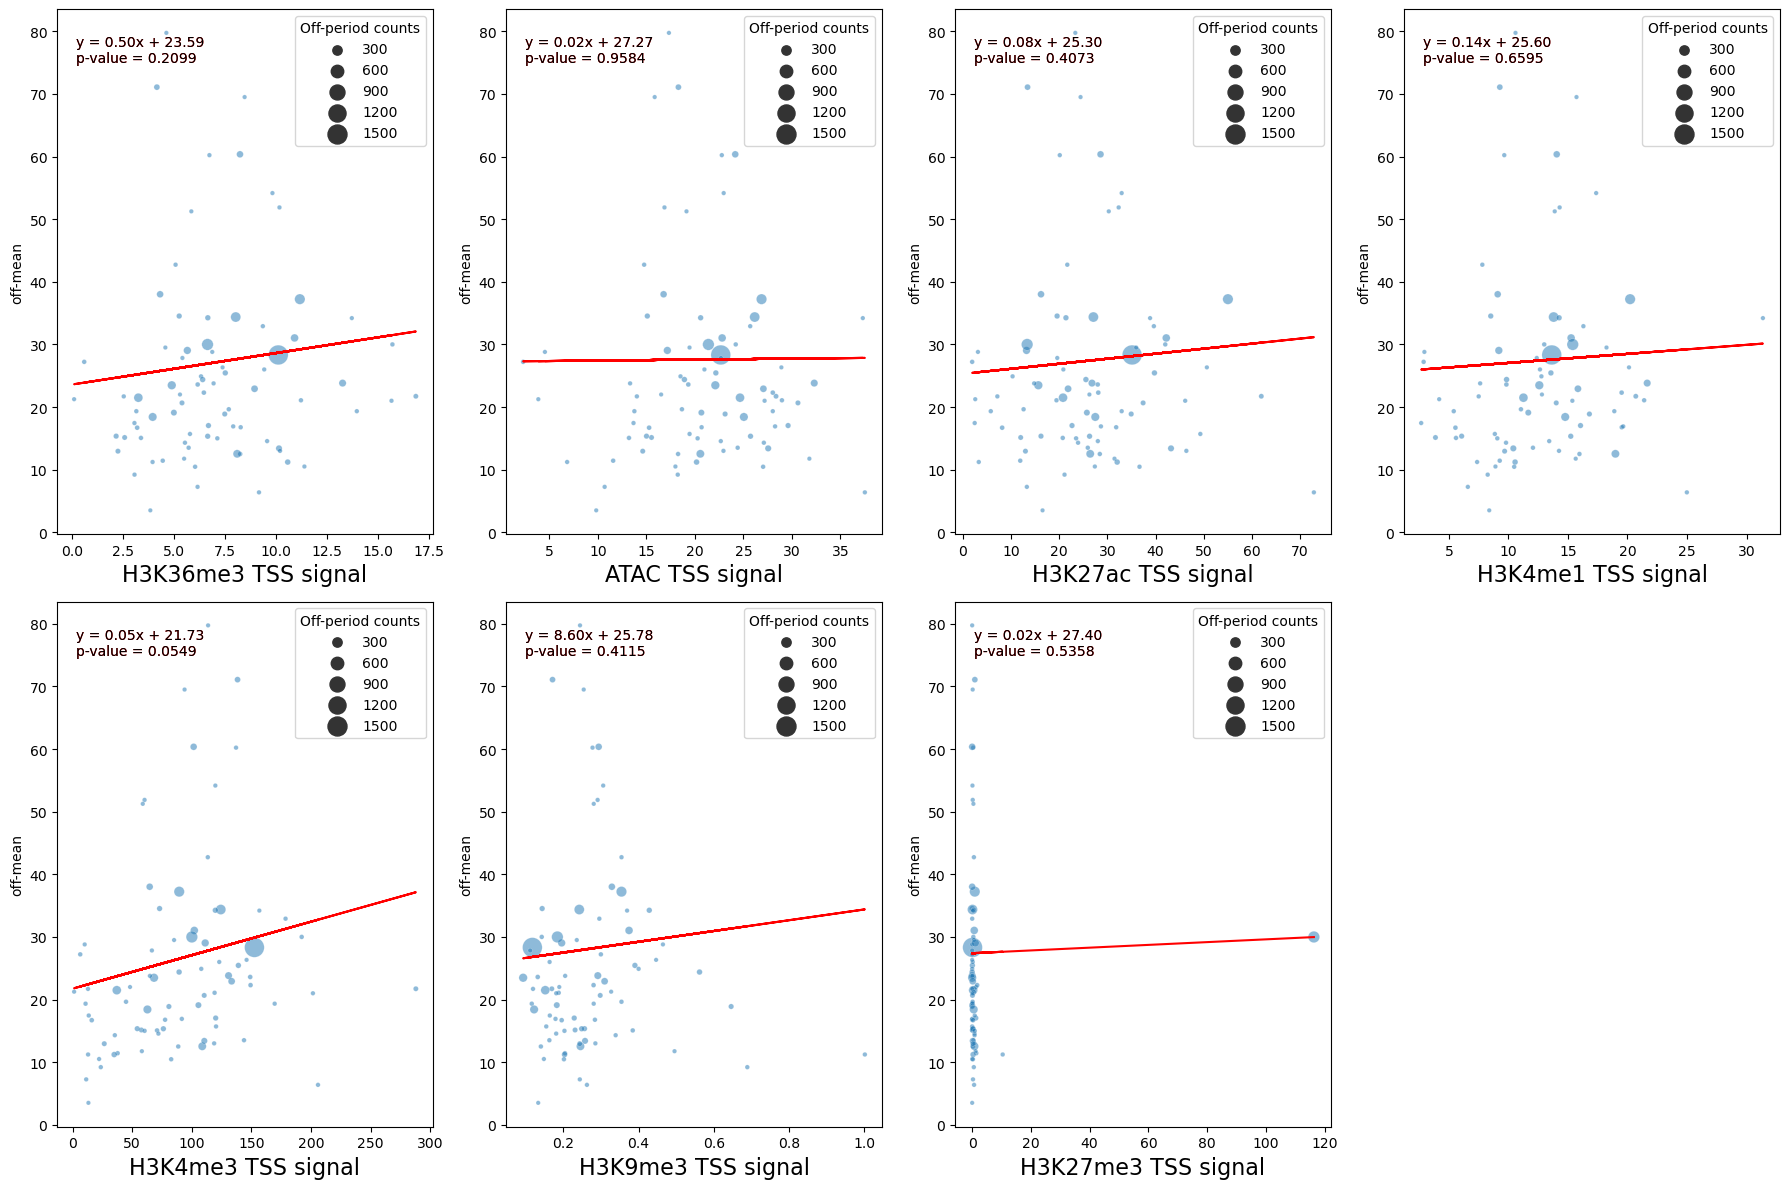

In [39]:
data = df[~df.gene.isin({'TPM4', 'ZMYND8', 'CELF1', 'AKAP12'})]


columns = ['H3K36me3_tss_mean',
           'ATAC_tss_mean',
           'H3K27ac_tss_mean',
           'H3K4me1_tss_mean',
           'H3K4me3_tss_mean', 
           'H3K9me3_tss_mean',
           'H3K27me3_tss_mean',
          ]

plt.figure(figsize=(18, 12))

model_info = []
for i, col in enumerate(columns):
    y_col = 'off-mean' #'off-median' #'off-mean' # 'K-on-rate'
    x_col = col

    ax = plt.subplot(2, 4, i + 1)
    sns.scatterplot(ax=ax, data=data, x=x_col, y=y_col, size='off-period-counts', 
                    sizes=(10, 200), alpha=0.5, marker='o')

    # Prepare data for weighted regression
    x = data[x_col]
    y = data[y_col] #.dropna()  # Drop NaN values

    weights = data['off-period-counts']  # Use off-period-counts as weights

    # Weighted regression
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()

    # Plot regression line
    m = model.params[1]
    b = model.params[0]
    p = model.pvalues[1]
    ax.plot(x, m*x + b, color='red')

    # Annotate with regression equation and p-value
    ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')

    if p < 0.05:
        color = "red"
    else:
        color = "black"
    ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', color=color)

    ax.set_xlabel(x_col.replace("_", " ").replace("mean", "signal").replace("tss", "TSS"), fontsize=16)
    ax.set_ylabel(y_col)
    #ax.set_title(f' {y_col} vs {x_col}\n quantile normalized of HBEC/H9DO/H9D3 ')
   
    # Legend for size scale
    ax.legend(title='Off-period counts', loc='upper right')
    
    print(col, f'{m:.2f}  {p:.4f}')
    model_info.append(f'{m:.2f}')
    model_info.append(f'{p:.4f}')
print(' '.join(map(str, model_info)))
plt.savefig("figs/TSS epi vs mean off period - exclude multi promoter.tif", format='tiff')
plt.tight_layout()
plt.show()



In [36]:

# # Define the columns for plotting
# columns = ['H3K36me3_genebody-wo-tss_mean',
#            'ATAC_genebody-wo-tss_mean',
#            'H3K27ac_genebody-wo-tss_mean',
#            'H3K4me1_genebody-wo-tss_mean',
#            'H3K4me3_genebody-wo-tss_mean', 
#            'H3K9me3_genebody-wo-tss_mean',
#            'H3K27me3_genebody-wo-tss_mean',
#           ]

# plt.figure(figsize=(20, 12))

# model_info = []
# for i, col in enumerate(columns):
#     y_col = 'off-mean' #'off-median' #'off-mean' # 'K-on-rate'
#     x_col = col

#     ax = plt.subplot(2, 4, i + 1)
#     sns.scatterplot(ax=ax, data=data, x=x_col, y=y_col, size='off-period-counts', 
#                     sizes=(10, 200), alpha=0.5, marker='o')

#     # Prepare data for weighted regression
#     x = data[x_col]
#     y = data[y_col] #.dropna()  # Drop NaN values

#     weights = data['off-period-counts']  # Use off-period-counts as weights

#     # Weighted regression
#     X = sm.add_constant(x)
#     model = sm.WLS(y, X, weights=weights).fit()

#     # Plot regression line
#     m = model.params[1]
#     b = model.params[0]
#     p = model.pvalues[1]
#     ax.plot(x, m*x + b, color='red')

#     # Annotate with regression equation and p-value
#     if p < 0.05:
#         color = "red"
#     else:
#         color = "black"
#     ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p:.4f}', 
#             transform=ax.transAxes, fontsize=10, verticalalignment='top', color=color)

#     ax.set_xlabel(x_col.replace("_", " ").replace("mean", "signal"), fontsize=16)
#     ax.set_ylabel(y_col)
#     #ax.set_title(f' {y_col} vs {x_col}\n quantile normalized of HBEC/H9DO/H9D3 ')
    
#     # Legend for size scale
#     ax.legend(title='Off-period counts', loc='upper right')

#     print(col, f'{m:.2f}  {p:.4f}')
#     model_info.append(f'{m:.2f}')
#     model_info.append(f'{p:.4f}')
# print(' '.join(map(str, model_info)))

# plt.savefig("figs/quantile normalized genebody-wo-tss epi vs mean off period.tif", format='tiff')

# plt.tight_layout()
# plt.show()

H3K36me3_genebody_mean -0.56  0.0344
-0.56 0.0344


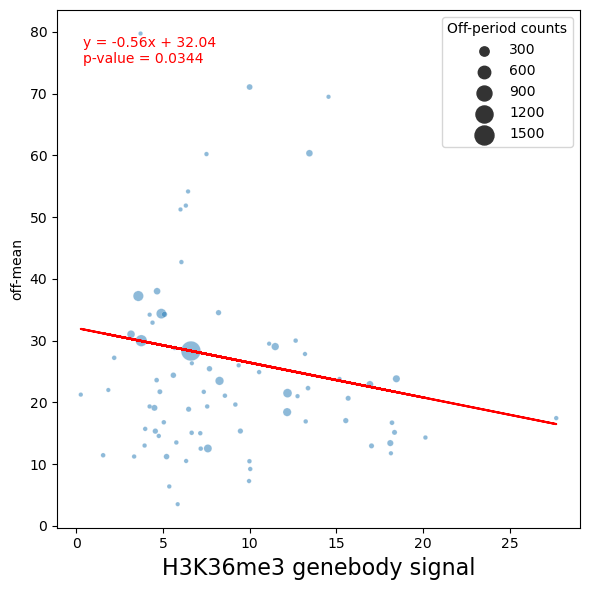

In [38]:

# Define the columns for plotting
columns = ['H3K36me3_genebody_mean',
          ]

plt.figure(figsize=(6, 6))

model_info = []
for i, col in enumerate(columns):
    y_col = 'off-mean' #'off-median' #'off-mean' # 'K-on-rate'
    x_col = col

    ax = plt.subplot(1, 1, i + 1)
    sns.scatterplot(ax=ax, data=data, x=x_col, y=y_col, size='off-period-counts', 
                    sizes=(10, 200), alpha=0.5, marker='o')

    # Prepare data for weighted regression
    x = data[x_col]
    y = data[y_col] #.dropna()  # Drop NaN values

    weights = data['off-period-counts']  # Use off-period-counts as weights

    # Weighted regression
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()

    # Plot regression line
    m = model.params[1]
    b = model.params[0]
    p = model.pvalues[1]
    ax.plot(x, m*x + b, color='red')

    # Annotate with regression equation and p-value
    if p < 0.05:
        color = "red"
    else:
        color = "black"
    ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', color=color)

    ax.set_xlabel(x_col.replace("_", " ").replace("mean", "signal"), fontsize=16)
    ax.set_ylabel(y_col)
    #ax.set_title(f' {y_col} vs {x_col}\n quantile normalized of HBEC/H9DO/H9D3 ')
    
    # Legend for size scale
    ax.legend(title='Off-period counts', loc='upper right')

    print(col, f'{m:.2f}  {p:.4f}')
    model_info.append(f'{m:.2f}')
    model_info.append(f'{p:.4f}')
print(' '.join(map(str, model_info)))

plt.savefig("figs/genebody epi vs mean off period.tif", format='tiff')

plt.tight_layout()
plt.show()

# distributionss

In [23]:

df_off = pd.DataFrame(columns=['gene', 'celltype', 'off-period'])
for index, row in df.iterrows():
    gene = row['gene']
    celltype = row['celltype']

    # Extract off-period values from the string
    off_periods = [int(period) for period in re.findall(r'\d+', row['off-period'])]
    
    # Append each off-period to the new DataFrame
    for off_period in off_periods:
        if off_period >= 2:
            df_off = df_off.append({'gene': gene, 'celltype': celltype, 'off-period': off_period}, ignore_index=True)


df_off['off-period'] = df_off['off-period'].astype(int)
df_off = pd.merge(df_off, df.drop('off-period', axis=1), on=["gene", "celltype"])
df_off.shape

(7105, 68)

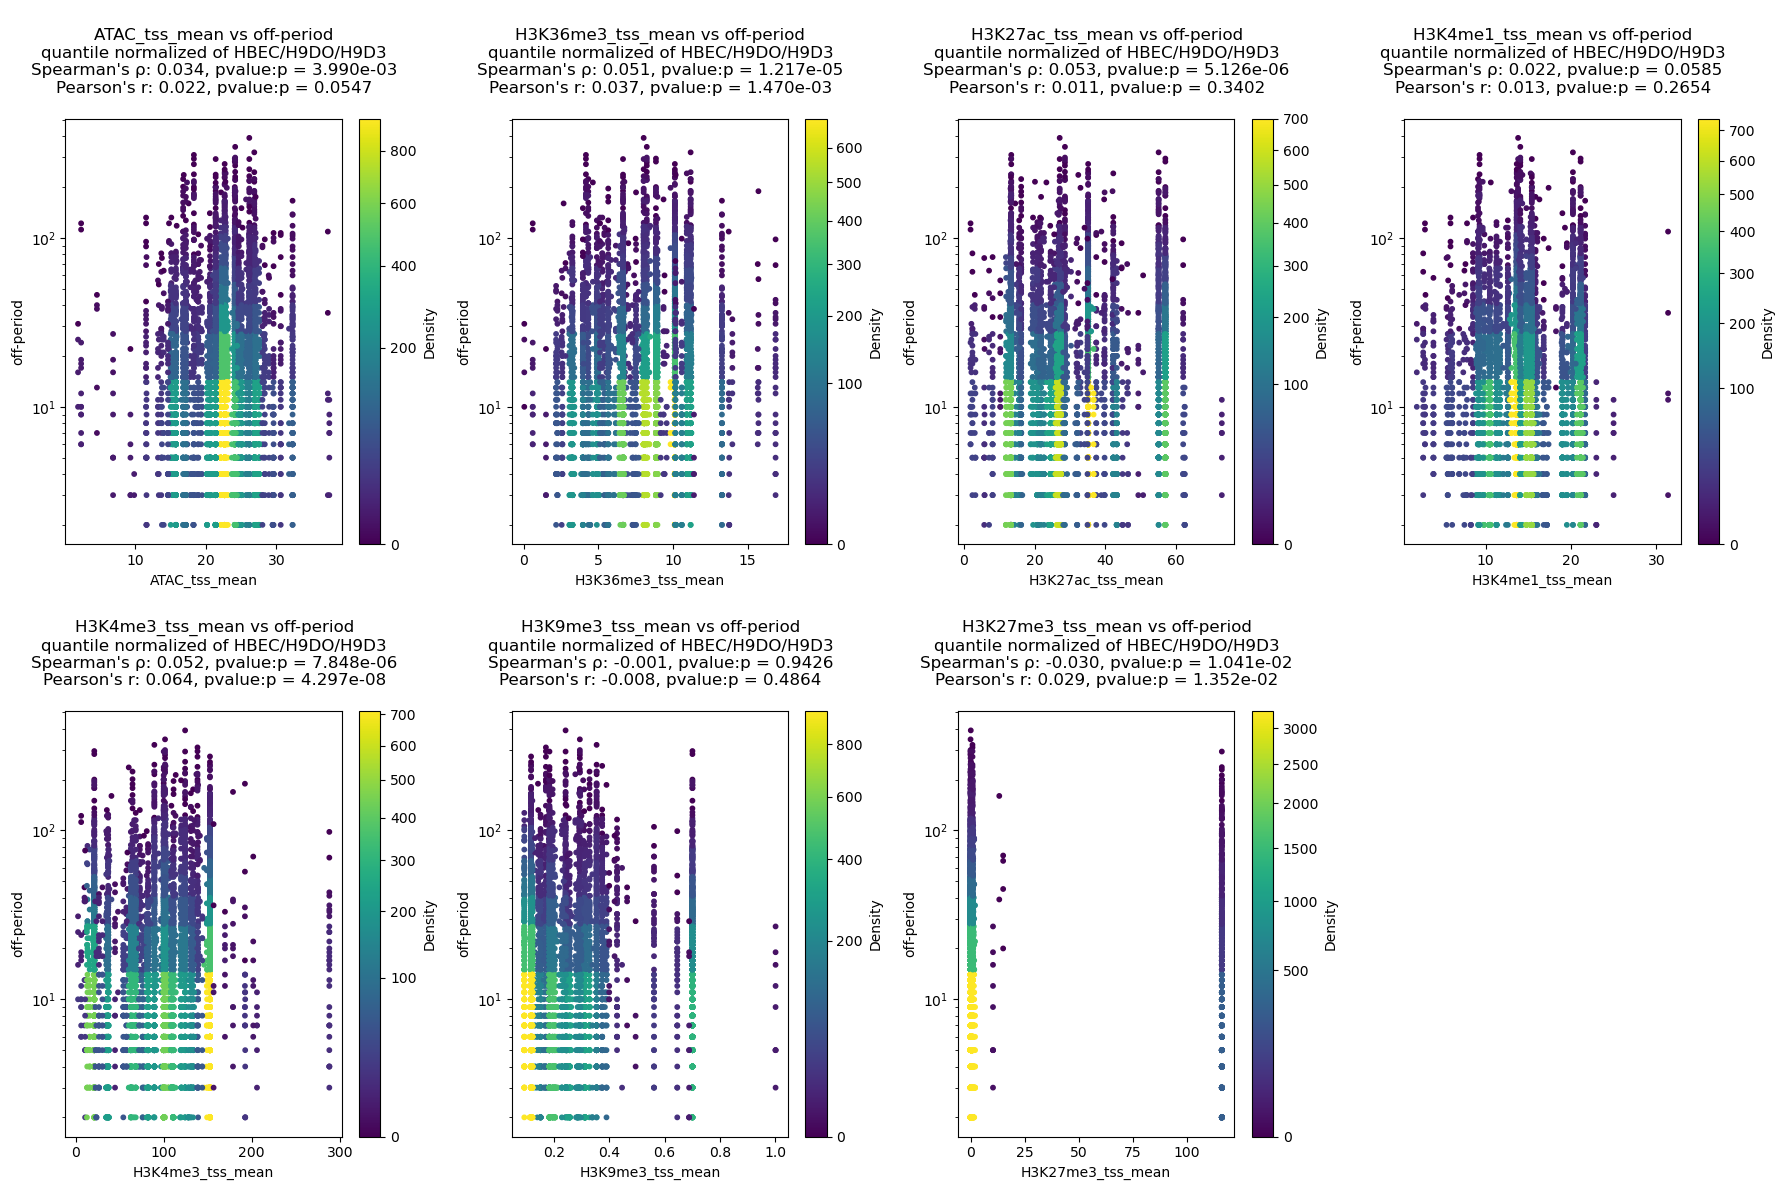

In [163]:
def calculate_point_density(x, y, bins=30):
    xy = np.vstack([x, y])
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    xidx = np.clip(np.digitize(x, xedges) - 1, 0, bins - 1)
    yidx = np.clip(np.digitize(y, yedges) - 1, 0, bins - 1)
    return hist[xidx, yidx]


data = df_off

# Define the columns for plotting
columns = ['ATAC_tss_mean',
           'H3K36me3_tss_mean',
           'H3K27ac_tss_mean',
           'H3K4me1_tss_mean',
           'H3K4me3_tss_mean', 
           'H3K9me3_tss_mean',
           'H3K27me3_tss_mean',
          ]

plt.figure(figsize=(18, 12))

for i, col in enumerate(columns):
    
    # Calculate Spearman's and Pearson's correlation coefficients
    spearman_corr, spearman_pval = spearmanr(data[col], data['off-period'])
    pearson_corr, pearson_pval = pearsonr(data[col], data['off-period'])
    spearman_pval = f'p = {spearman_pval:.3e}' if spearman_pval < 0.05 else f'p = {spearman_pval:.4f}'
    pearson_pval = f'p = {pearson_pval:.3e}' if pearson_pval < 0.05 else f'p = {pearson_pval:.4f}'
    
    ax = plt.subplot(2, 4, i + 1)
    
    z = calculate_point_density(data[col], data['off-period'])
    
    sc = ax.scatter(data[col], data['off-period'], c=z, cmap='viridis', norm=PowerNorm(0.5), s=10)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Density')
    
    # Set axis labels and title
    
    ax.set_xlabel(col)
    ax.set_ylabel('off-period')
    ax.set_title(f"""
    {col} vs off-period
    quantile normalized of HBEC/H9DO/H9D3
    Spearman's ρ: {spearman_corr:.3f}, pvalue:{spearman_pval}
    Pearson's r: {pearson_corr:.3f}, pvalue:{pearson_pval}
    """)
    
    #ax.set_ylim(top=data['off-period'].quantile(0.99)) 
    ax.set_yscale('log')


plt.tight_layout()
plt.show()



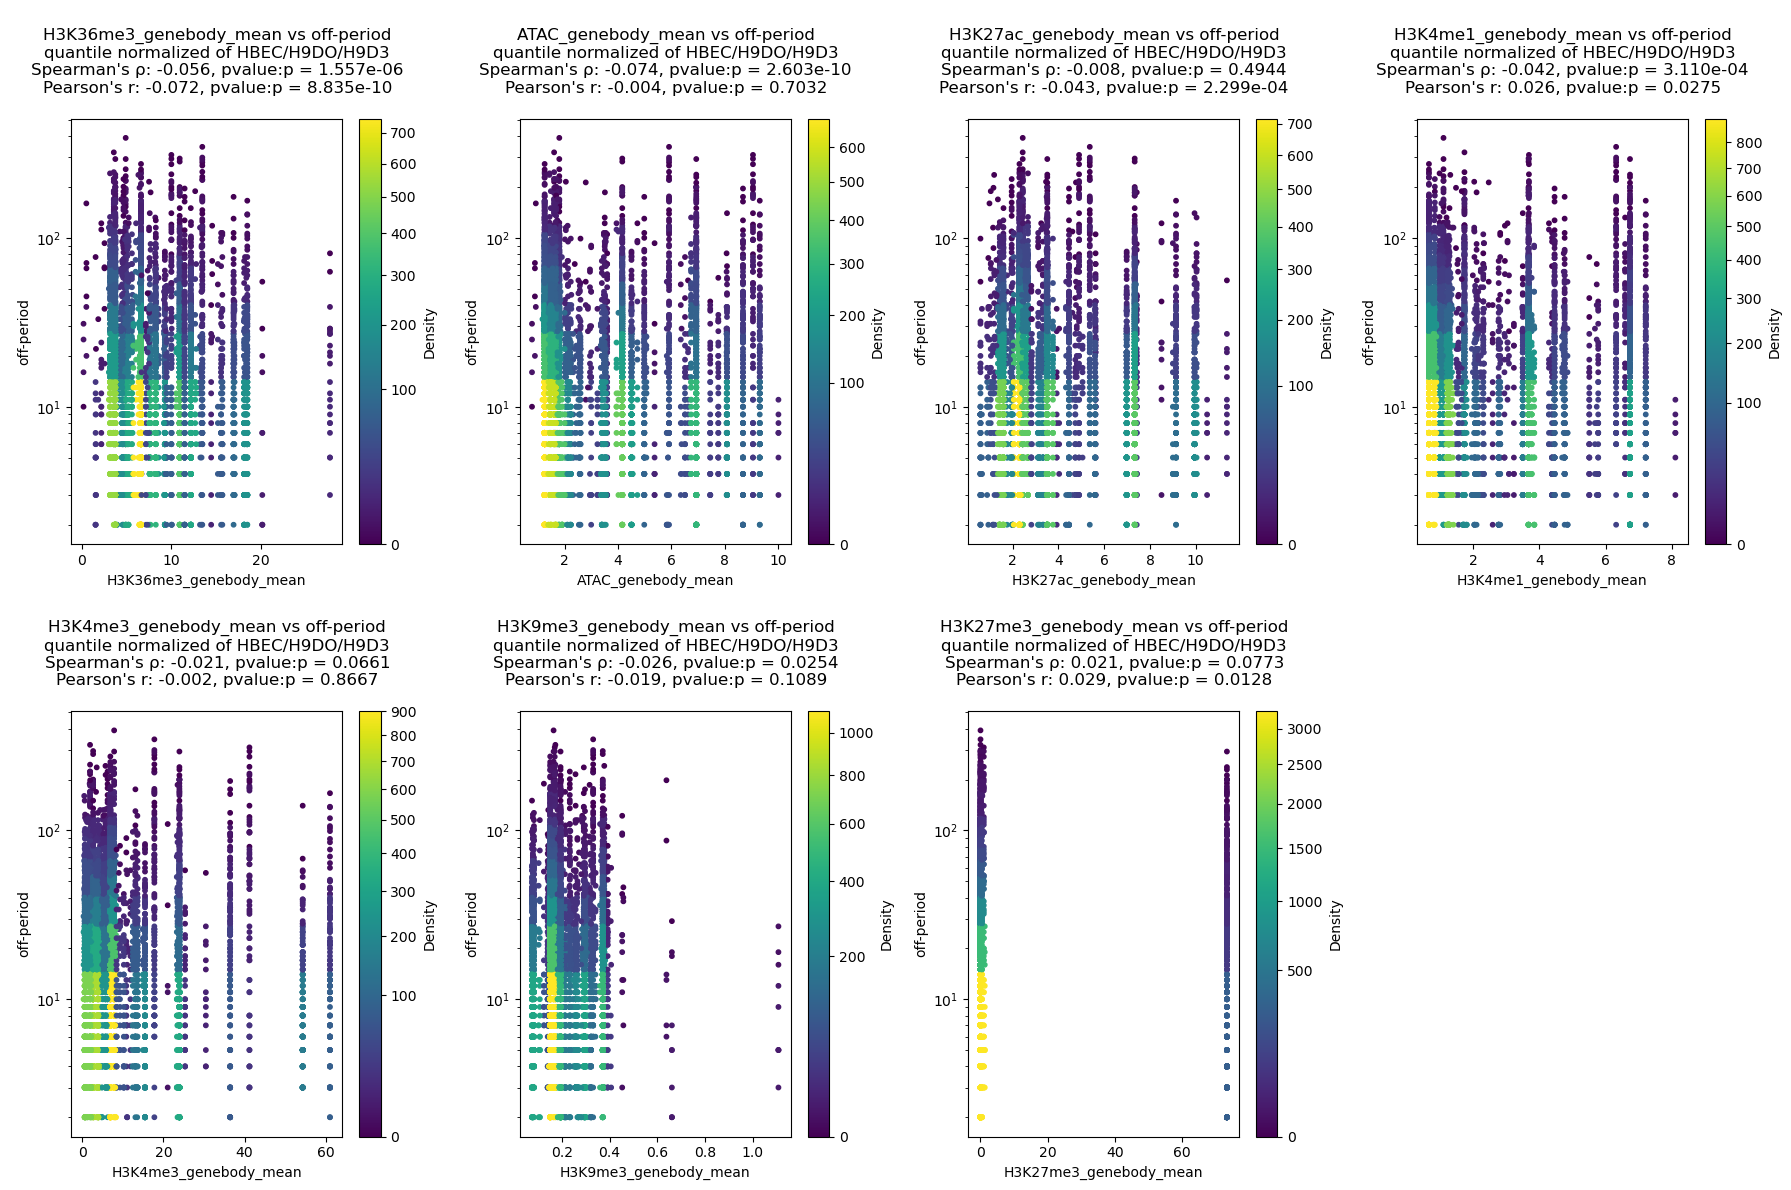

In [165]:
columns = ['H3K36me3_genebody_mean',
           'ATAC_genebody_mean',
           
           
           'H3K27ac_genebody_mean',
           'H3K4me1_genebody_mean',
           'H3K4me3_genebody_mean', 
           'H3K9me3_genebody_mean',
           'H3K27me3_genebody_mean',
          ]


plt.figure(figsize=(18, 12))

for i, col in enumerate(columns):
    
    # Calculate Spearman's and Pearson's correlation coefficients
    spearman_corr, spearman_pval = spearmanr(data[col], data['off-period'])
    pearson_corr, pearson_pval = pearsonr(data[col], data['off-period'])
    spearman_pval = f'p = {spearman_pval:.3e}' if spearman_pval < 0.01 else f'p = {spearman_pval:.4f}'
    pearson_pval = f'p = {pearson_pval:.3e}' if pearson_pval < 0.01 else f'p = {pearson_pval:.4f}'
    
    
    ax = plt.subplot(2, 4, i + 1)
    
    z = calculate_point_density(data[col], data['off-period'])
    
    sc = ax.scatter(data[col], data['off-period'], c=z, cmap='viridis', norm=PowerNorm(0.5), s=10)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Density')
    
    # Set axis labels and title

    ax.set_xlabel(col)
    ax.set_ylabel('off-period')
    ax.set_title(f"""
    {col} vs off-period
    quantile normalized of HBEC/H9DO/H9D3
    Spearman's ρ: {spearman_corr:.3f}, pvalue:{spearman_pval}
    Pearson's r: {pearson_corr:.3f}, pvalue:{pearson_pval}
    """)
    
    #ax.set_ylim(top=data['off-period'].quantile(0.99)) 
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

